In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport utils

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from utils import load_embeddings_and_ids, concatenate_featmats, plot_images

### Loading Features

In [4]:
resnet50 = load_embeddings_and_ids('/mnt/workspace/Ugallery/ResNet50/', 'flatten_1.npy', 'ids')

In [5]:
# grammat_b1c1 = load_embeddings_and_ids('/mnt/workspace/Ugallery/gram_matrix/', 'block1_conv1.npy', 'ids')

In [6]:
resnext101 = load_embeddings_and_ids('/mnt/workspace/Ugallery/resnext101_32x8d_wsl/', 'features.npy', 'ids.npy')

In [5]:
# alexnet = load_embeddings_and_ids('/mnt/workspace/Ugallery/AlexNet/', 'fc7.npy', 'ids.npy')

In [6]:
# inceptionv3 = load_embeddings_and_ids('/mnt/workspace/Ugallery/InceptionV3/', 'avg_pool.npy', 'ids')

In [7]:
# vgg19 = load_embeddings_and_ids('/mnt/workspace/Ugallery/VGG19/', 'fc2.npy', 'ids')

In [8]:
# incepresv2 = load_embeddings_and_ids('/mnt/workspace/Ugallery/InceptionResnetV2/', 'avg_pool.npy', 'ids')

In [44]:
embedding_list = [
    resnet50,
    resnext101,
#     grammat_b1c1,
#     alexnet,
#     inceptionv3,
#     vgg19,
#     incepresv2,
]

### Combining features and applying PCA

In [45]:
artwork_ids = set()
for tmp in embedding_list:
    if len(artwork_ids) == 0:
        artwork_ids.update(tmp['index2id'])
    else:artwork_ids.intersection_update(tmp['index2id'])

In [46]:
len(artwork_ids)

13297

In [47]:
featmat_list = [tmp['featmat'] for tmp in embedding_list]
id2index_list = [tmp['id2index'] for tmp in embedding_list]
concat_featmat = concatenate_featmats(artwork_ids, featmat_list, id2index_list)

In [48]:
concat_featmat.shape

(13297, 4096)

In [49]:
std_scaler = StandardScaler()

In [50]:
concat_featmat_zscored = std_scaler.fit_transform(concat_featmat)

In [51]:
pca200_concat = PCA(n_components=200).fit_transform(concat_featmat_zscored)

In [52]:
pca200_concat.shape

(13297, 200)

In [53]:
pca400_concat = PCA(n_components=400).fit_transform(concat_featmat_zscored)

In [54]:
pca400_concat.shape

(13297, 400)

In [56]:
from os import makedirs
# dirpath = '/mnt/workspace/Ugallery/PCA200(resnet50+alexnet+inceptionv3+vgg19+incepresv2)/'
dirpath = '/mnt/workspace/Ugallery/PCA400(resnet50+resnext101)/'
makedirs(dirpath, exist_ok=True)
np.save(dirpath + 'embeddings.npy', pca400_concat)
np.save(dirpath + 'ids.npy', np.array(list(artwork_ids)))

### K-Means Clustering

In [57]:
best_score=None
best_clusterer=None

In [59]:
_embeddings = pca400_concat
for _ in range(10):
    print(_,' ---------------------------------')
    clusterer = KMeans(n_clusters=100, max_iter=2000, n_init=8, n_jobs=8).fit(_embeddings)
    cluster_labels = clusterer.predict(_embeddings)
    silhouette_avg = silhouette_score(_embeddings, cluster_labels)
    if best_score is None or best_score < silhouette_avg:
        best_score = silhouette_avg
        best_clusterer = clusterer
    print("Average silhouette_score is :", silhouette_avg)

0  ---------------------------------
Average silhouette_score is : 0.023798169315032213
1  ---------------------------------
Average silhouette_score is : 0.023765111561082387
2  ---------------------------------
Average silhouette_score is : 0.024025790889214266
3  ---------------------------------
Average silhouette_score is : 0.02479295309964696
4  ---------------------------------
Average silhouette_score is : 0.023367318007116774
5  ---------------------------------
Average silhouette_score is : 0.02182727030875787
6  ---------------------------------
Average silhouette_score is : 0.023840638725584267
7  ---------------------------------
Average silhouette_score is : 0.022079227151872195
8  ---------------------------------
Average silhouette_score is : 0.02599626352628598
9  ---------------------------------
Average silhouette_score is : 0.02358892919746196


In [60]:
index2id = list(artwork_ids)

In [61]:
best_cluster_labels = best_clusterer.predict(pca200_concat)

In [62]:
silhouette_score(pca200_concat, best_cluster_labels)

0.04025390047172921

In [67]:
artwork_id_2_cluster_id = { str(aid):int(cid) for aid,cid in zip(index2id, best_cluster_labels) }

In [68]:
import json
from os import makedirs
makedirs('/mnt/workspace/Ugallery/Clustering/', exist_ok=True)
# with open('/mnt/workspace/Ugallery/Clustering/artworkId2clusterId(resnet50+alexnet+inceptionv3+vgg19+incepresv2).json',
with open('/mnt/workspace/Ugallery/Clustering/artworkId2clusterId(resnet50+resnext101).json',
          'w') as f:
    json.dump(artwork_id_2_cluster_id, f)

### Visualize Clusters

In [4]:
import json
import random
import matplotlib.pyplot as plt

In [5]:
with open('/mnt/workspace/Ugallery/Clustering/artworkId2clusterId(resnet50+resnext101).json') as f:
    artwork_id_2_cluster_id = json.load(f)

In [7]:
artwork_id_2_cluster_id = {int(k):v for k,v in artwork_id_2_cluster_id.items()}

In [9]:
N_CLUSTERS = len(set(artwork_id_2_cluster_id.values()))
N_CLUSTERS

100

In [10]:
image_cache = dict()

In [11]:
artwork_ids_by_cluster = {i:[] for i in range(N_CLUSTERS)}
for aid,cid in artwork_id_2_cluster_id.items():
    artwork_ids_by_cluster[cid].append(aid)
for i in range(N_CLUSTERS):
    assert len(artwork_ids_by_cluster[i]) > 0

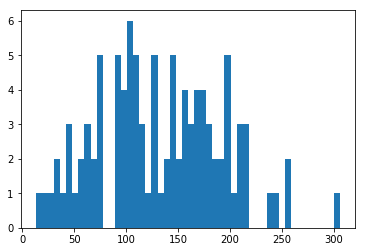

In [12]:
plt.hist([len(x) for x in artwork_ids_by_cluster.values()], bins=50)
plt.show()

In [13]:
def plot_image_sample(cluster_id=None, n_samples=20, n_clusters=100):
    if cluster_id is None:
        cluster_id = np.random.randint(n_clusters)
        
    ids = artwork_ids_by_cluster[cluster_id]
    if len(ids) > n_samples:
        sample_ids = random.sample(ids, n_samples)
    else:
        sample_ids = ids
    n = len(sample_ids)
    
    print('----- cluster_id = %d, size = %d ------' % (cluster_id, len(ids)))
        
    plot_images(plt, image_cache, sample_ids)

----- cluster_id = 6, size = 181 ------


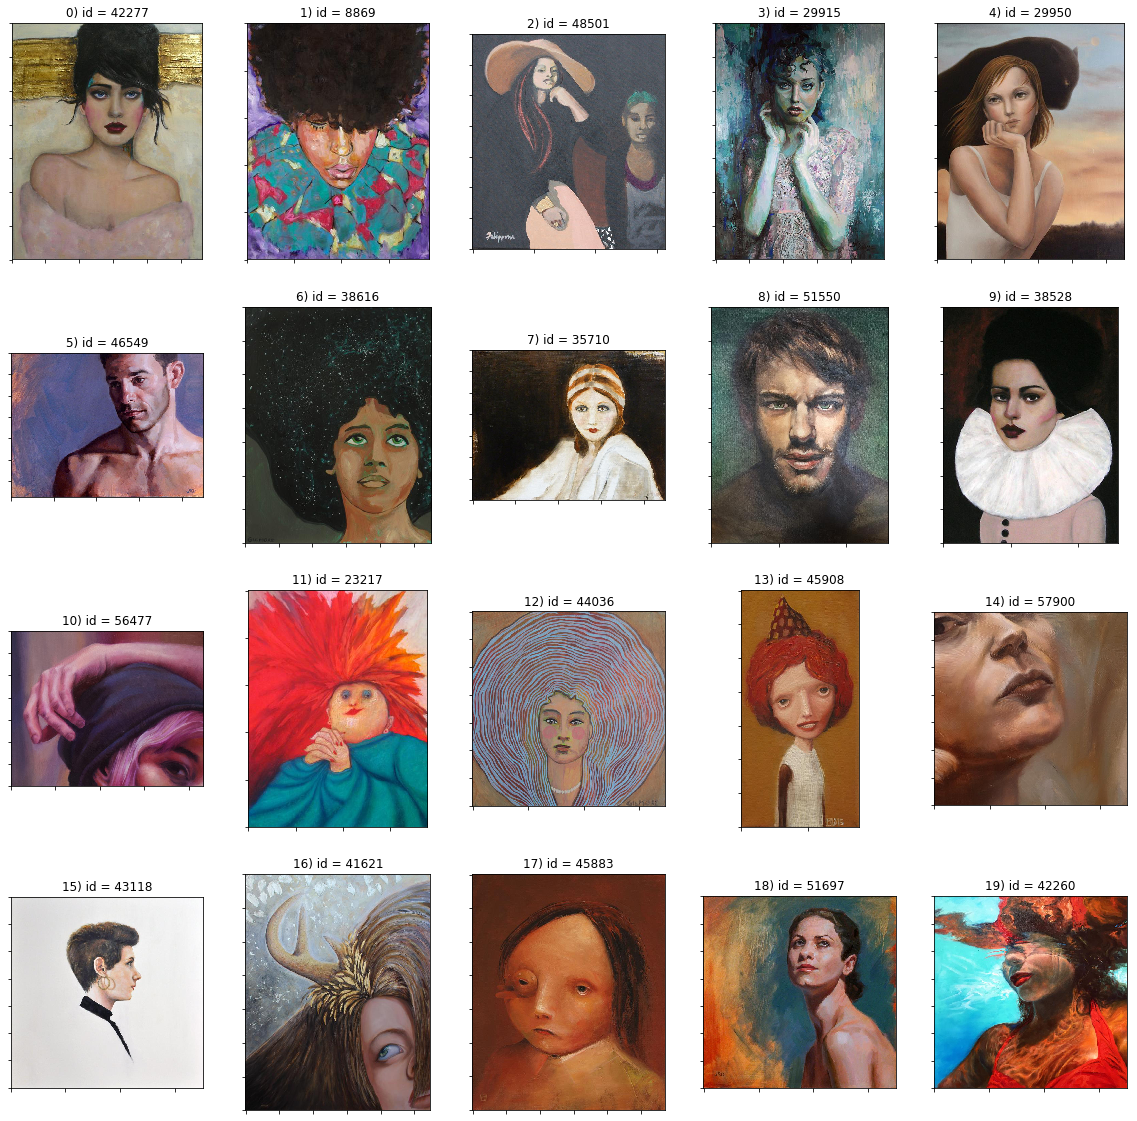

In [22]:
plot_image_sample(cluster_id=None, n_samples=20)